In [1]:
%matplotlib inline

In [2]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16

# Hide deprecation warnings from Theano
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
period_guess = 6.26554
t0_guess = -1.19041

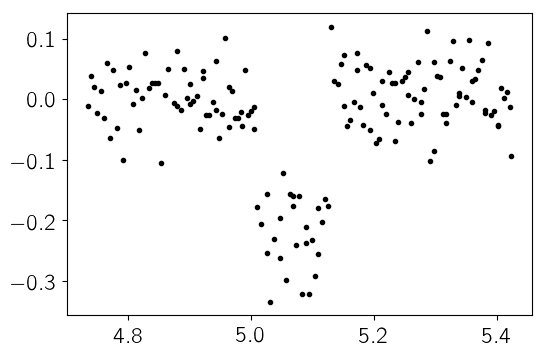

In [4]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

with fits.open("data/pimen-ffi.fits") as hdus:
    data = hdus[1].data
    hdr = hdus[1].header
    
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
    
x = np.array(data["time"], dtype=np.float64)
y = np.array(data["flux"], dtype=np.float64)

plt.plot(x % period_guess, y, ".k");

In [13]:
import pymc3 as pm
import theano.tensor as tt
import exoplanet as xo

with pm.Model() as model:
    logs = pm.Normal("logs", mu=np.log(np.std(y)), sd=5.0)
    mean_flux = pm.Normal("mean_flux", mu=0, sd=1)
    u = xo.distributions.QuadLimbDark("u")
    logperiod = pm.Normal("logperiod", mu=np.log(period_guess), sd=1)
    period = pm.Deterministic("period", tt.exp(logperiod))
    t0 = pm.Normal("t0", mu=t0_guess, sd=1)
    r, b = xo.distributions.get_joint_radius_impact(
        min_radius=0.005, max_radius=0.05, testval_r=0.015)
    
    orbit = xo.orbits.KeplerianOrbit(
        period=period, t0=t0, b=b)
    star = xo.StarryLightCurve(u)
    light_curve = tt.squeeze(star.get_light_curve(
        orbit=orbit, r=r, t=x, texp=texp))*1e3 + mean_flux
    
    pm.Normal("obs", mu=light_curve, sd=tt.exp(logs), observed=y)

[0.5]


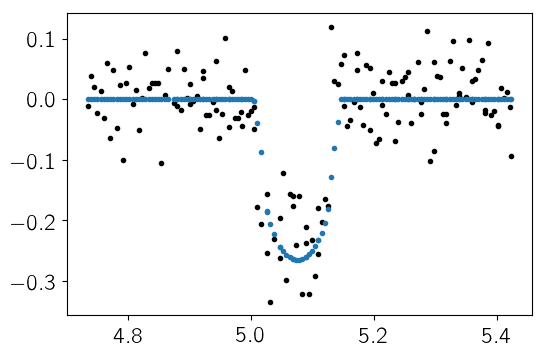

In [14]:
with model:
    lc_model = xo.utils.eval_in_model(light_curve)
    print(xo.utils.eval_in_model(orbit.b))
    
plt.plot(x % period_guess, y, ".k")
plt.plot(x % period_guess, lc_model, ".")

In [15]:
np.random.seed(42)
sampler = xo.PyMC3Sampler(finish=200)
with model:
    sampler.tune(tune=1000, step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=2000)

Sampling 2 chains: 100%|██████████| 404/404 [00:03<00:00, 115.75draws/s]
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rb, t0, logperiod, u, mean_flux, logs]
INFO:pymc3:NUTS: [rb, t0, logperiod, u, mean_flux, logs]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:37<00:00, 107.39draws/s]


In [16]:
pm.summary(trace, varnames=["period", "t0", "r", "b"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
period,6.269588,0.001374,0.000024,6.266853,6.272239,2635.642241,0.999807
t0,-1.197692,0.001926,0.000038,-1.201448,-1.193913,2950.016468,0.999750
r__0,0.014930,0.000566,0.000012,0.013788,0.015949,2039.303039,1.000472
b__0,0.505761,0.080146,0.002001,0.344588,0.631590,1367.635598,1.000167


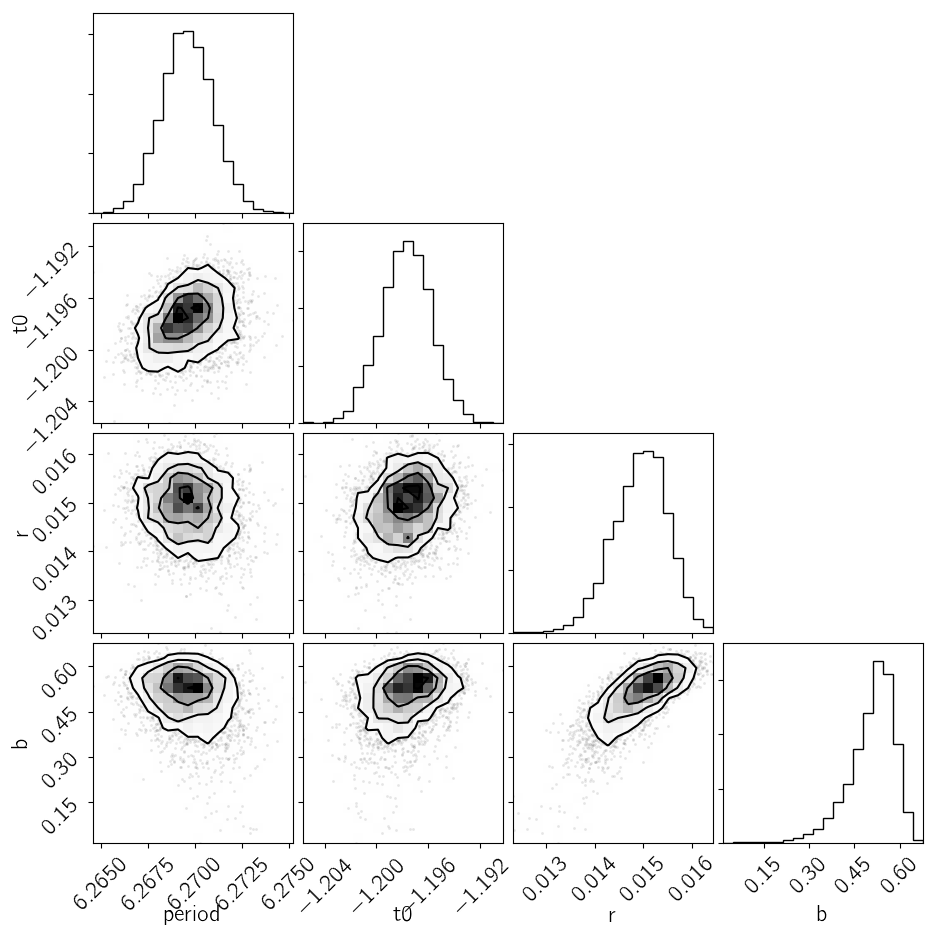

In [17]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["period", "t0", "r", "b"])
for k in samples.columns:
    if "_" in k:
        samples[k.split("_")[0]] = samples[k]
        del samples[k]

corner.corner(samples);